In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [ ]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback, CSVLogger
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
from caption_generator_api.utils import *
from caption_generator_api.BeamSearch import *
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Non-competitive part

In this part of the assignment we had to implement encoder for the images and a decoder for text captions in this part along with beam search to find the most optimal sequence.

## Pre-processing

* Building on the `starter_code.py`, the captions were first enclosed within `START` and `END` tokens, and then padded with PAD tokens to make them all fixed length. Let's call this fixed length $l$.

* The captions were tokenized at word-level. Character-level tokenization with OCR task was considered, but we didn't have the right dataset to train an OCR like model.
* After tokenization, they were converted into one-hot vectors. There were $7739$ tokens.
* Images were resized to fixed size. Thresholding the images to remove the background details and converting to grayscale was tried, it didn't help.
* In images, we used the EAST text detector in opencv to crop tightly to the text. The results were poor.
* In conclusion, the captions were tokenized, enclosed in start and end markers and padded to fixed length $l$ after which a vocabulary mapped it to integers which was then mapped to one-hot encodings. Images were resized to fixed width-height.

Here is the code for tokenization, 

In [ ]:
def gen_vocab(this):
    captions_dict = this.captions_dict
    words = dict()
    for k in captions_dict:
    for token in captions_dict[k].strip().split():
        words[token] = 1
    vocab = {k: v+3 for v, k in enumerate(words)}
    vocab['xxpad'] = 0
    vocab['xxstart'] = 1
    vocab['xxend'] = 2
    vocab['xxunk'] = len(vocab.keys())
    return vocab 

## CNN Encoder

We made a simple CNN block to extract features from images comprising of convolutional layers and pooling layers. Default kernel size and stride size were used.

Different layers used in the encoder, 

In [ ]:
this.convs = nn.ModuleList()
this.convs.append(nn.Conv2d(indim, hiddenconvdim,(7,7)))
this.nconvs = 3
for _ in range(this.nconvs-1):
    this.convs.append(nn.Conv2d(hiddenconvdim,hiddenconvdim,(7,7)))
this.flatten = nn.Conv2d(hiddenconvdim,1,(3,3),padding=1,padding_mode='replicate')

Code for forward pass through the encoder,

In [ ]:
for i in range(this.nconvs):
    image_batch = this.convs[i](image_batch)
    image_batch = F.dropout(image_batch,p=0.1,training=this.training)
    image_batch = F.relu_(image_batch)
image_batch = F.max_pool2d(image_batch,4,11)

## Attention

Code for attention, 

In [ ]:
bs,C,w,h = image_batch.size()
image_batch = image_batch.view(bs,-1,w*h)
bs,C,w,h = x.size()
x = x.view(bs,w*h,-1)
x = F.softmax(this.att_in(x),dim=2)
combined = torch.bmm(image_batch,x.permute(0,2,1))

## RNN Decoder

* The output of the CNN decoder was first fed into a linear layer to create attention weights. It was then multiplied with features output by encoder.
* This was then passed into two other linear layers which would output initial hidden state and cell state to be used by RNN decoder.
* We used `torch.nn.LSTM` in biderectional mode first, 2 layers deep. We soon realized a problem here: this only gave the final output. So, we switched to `torch.nn.LSTMCell` that would give out the hidden and cell states at each time step and it can be used to run it for as many time steps as needed.
* So, in the `torch.nn.Module.forward` method (inherited by our model) we had a `for` loop running for the length of the sequence which was the same as $l$.
* The hidden state at each step is seen as the unnormalized log probabilities over all possible words.
* We did teacher-forcing, just as asked for.

Layers used in the decoder,

In [ ]:
this.rnn = nn.LSTMCell(lstmoutdim,lstmoutdim)
this.init_h = nn.Linear(22*22,lstmoutdim)
this.init_c = nn.Linear(22*22,lstmoutdim)

Forward pass through the encoder,

In [ ]:
mean_enc_out = combined.mean(dim=1)
h = this.init_h(mean_enc_out)
h = h.view(this.batch_size,this.lstmoutdim)
c = this.init_c(mean_enc_out)
c = c.view(this.batch_size,this.lstmoutdim)

max_len = this.lstmindim
pred = torch.zeros(this.batch_size,max_len,this.lstmoutdim,device=d)
curr_input = torch.zeros(this.batch_size,this.lstmoutdim,device=d)

#this is the start token
curr_input[:,1]=1 
pred[:,0,:] = curr_input

Teacher forcing is used here,

In [ ]:
for t in range(1,max_len):
    (h,c) = this.rnn(curr_input,(h,c))
    pred[:,t,:] = h
    if this.training:
        curr_input = captions_batch[:,t,:]
    else:
        curr_input = h

## Loss

We used negative log likelihood loss to maximize the likelihood of each word at each time step for each example. So,

\begin{align*}
P_v(x^{(i)})&=[\operatorname{softmax}(h_\theta(x^{(i)}))]_v, \; v\in V\\
LL(\theta;x,y)&=\sum_{i\in M}\sum_{t=1}^T\sum_{v\in V} 1\{y^{(i)}_t=v\}\log{P_v(x^{(i)})}
\end{align*}

where with abuse of notation, $h_\theta(x^{(i)})$ is used to mean the hidden state output by the rnn and time $t$ by the RNN decoder. $V$ is the set of all words, the vocabulary. \(M\) represents the mini-batch.

The parameters of the model, both encoder and decoder are then trained in an end-to-end fashion using SGD optimizer.

This is the loss function we have used,

In [ ]:
loss_function = nn.CrossEntropyLoss()

# Competitive Part

In this part of the assignment we used pre-trained CNN models for encoder.

In [18]:
data_dir = Path('/home/scai/phd/aiz218322/codefiles/col774/ass4/processed_data/')

path = Path('/home/cse/phd/anz198717/scratch/suchith_data/data/')

PATH = Path('data/')

metadata = pd.read_csv(path/"Train_text.tsv", sep="\t",header=None)
metadata.rename(columns={0:'filename', 1:'labels'}, inplace=True)

In [19]:
#metadata['filename'] = metadata.filename.apply(lambda x: f'{path}/{x}' )

processed_files = os.listdir(data_dir)
metadata['filename'] = metadata.filename.apply(lambda x: os.path.basename(x) )
metadata = metadata.set_index('filename').loc[processed_files].reset_index()
metadata['filename'] = metadata.filename.apply(lambda x: f'{data_dir}/{os.path.basename(x)}' )

In [20]:
def show_batch(df, num, rows=2, fs=(20, 10)):
    rand_idx = np.random.permutation(df.shape[0])[:num]
    files = df['filename'][rand_idx].values
    cols = int(np.ceil(num/rows))
    
    fig, ax = plt.subplots(rows, cols, figsize=fs)
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            
            if i < num:
                img = plt.imread(files[i])
                ax[r, c].imshow(img)
            ax[r, c].axis('off')

## Visualizing the data

Here are few images from the dataset provided to us for the assignment.

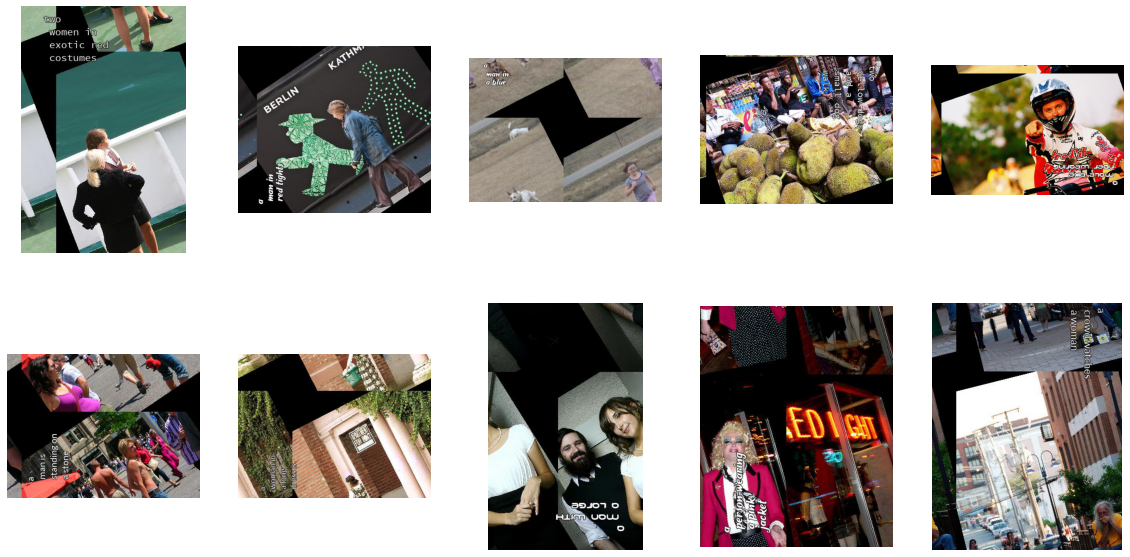

In [6]:
show_batch(metadata, 10)

* We thought that as it would be difficult to the model to first locate the text image and then extract the text, so we created another dataset where we extracted the text region from the image.
* For this we used, EAST text detector in opencv to crop tightly to the text.

Below are the images of the new dataset

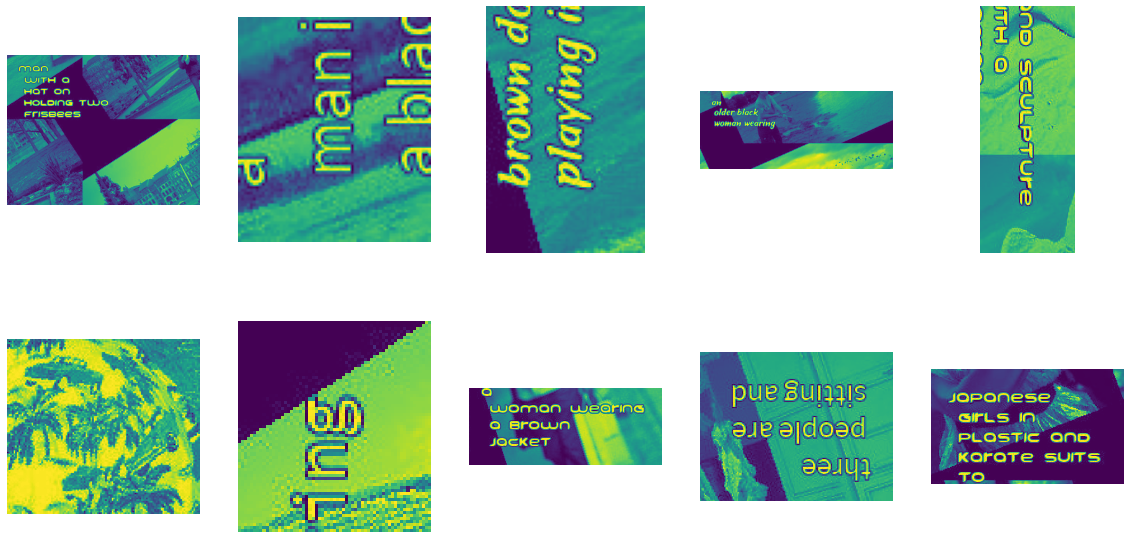

In [21]:
show_batch(metadata, 10)

We tried training the model using both the dataset.

## Preprocessing

For this part we used fastai library for pre-processing the text and convert into number so that it could be fed into the model.

In [ ]:
tokenizer = Tokenizer()
train_texts_tokenized = tokenizer.process_all(list(zip(*train_fns_txts))[1])
vocab = Vocab.create(train_texts_tokenized, max_vocab=50000, min_freq=2)

In [ ]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

The following function was used to create the training and validation data.

In [ ]:
def build_data(fns_txts, PATH, name):
    filenames, text = zip(*fns_txts)
    texts_tok = numericalize_tokens(tokenizer.process_all(text))
    dataset = (filenames, texts_tok)
    pickle.dump(dataset, open(str(PATH)+"/"+name+".pkl", 'wb'))

## Image Text Dataset

This is the custom PyTorch dataset, which will then be used to create the dataloader.

In [ ]:
class ImageTextDataset(Dataset):
    def __init__(self, data, transform=None):
        self.filenames = data[0]
        self.texts  = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx]).convert('RGB')
        text = self.texts[idx]
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, text)

These are the transformation on the image dataset, we have resize the image to size $224$.

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

valid_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

## CNN Encoder

Here we have used pretrained `resnet34` as our base network and added a few fully connected layer to feed it the RNN decoder part.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet34(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            fc_layer(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)

## Visual Attention

Code for visual attention.

In [ ]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)
        
    def forward(self, annotation_vecs, dec_hid_state):
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)
        alphas = F.softmax(e, dim=1)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)
        
        return context_vec, alphas

## Image Text Extractor

This is the entire encoder-decoder based module for text extraction.

In [ ]:
class ImageTextExtractor(nn.Module):
    def __init__(self, device, filter_width, num_filters, vocab_size, emb_sz, out_seqlen, n_layers=3, 
                 prob_teach_forcing=1, p_drop=0.3):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = nn.Embedding(vocab_size, emb_sz) 
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, 
                              dropout=0 if n_layers == 1 else p_drop)
        self.out_drop = nn.Dropout(p_drop)
        self.out = nn.Linear(emb_sz, vocab_size)
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)
        
        self.prob_teach_forcing = prob_teach_forcing
        self.initializer()
        
    def initializer(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y=None):
        h, annotation_vecs = self.encode(x)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            dec_output, h, alpha = self.decode_step(dec_inp, h, annotation_vecs)
            res.append(dec_output)
            alphas.append(alpha)
            
            if (dec_inp == 1).all() or (y is not None and i >= len(y)):
                break            
            # teacher forcing
            elif y is not None and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                dec_inp = y[i].to(self.device)
            else:
                dec_inp = dec_output.data.max(1)[1]

        return torch.stack(res), torch.stack(alphas)
    
    
    def encode(self, x):
        return self.encoder(x.to(self.device))
    
    def decode_step(self, dec_inp, h, annotation_vecs):
        context_vec, alpha = self.att(annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

## Training

Here we have used fastai learner.

In [ ]:
textExtractor = ImageCaptionGenerator(gpu, 7, 512, len(vocab.itos), emb_sz, 50, n_layers, p_drop=0.2)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, 
                loss_func=ImageCaptionLoss, callback_fns=[ShowGraph], metrics=[BleuMetric()])

learn.fit_one_cycle(5, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'))

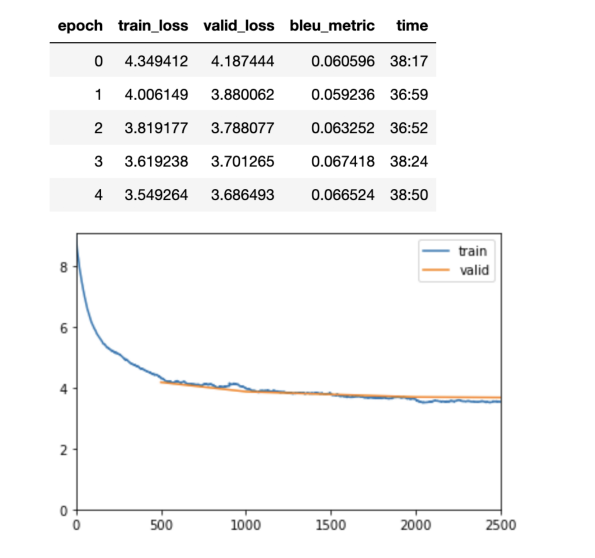

In [30]:
img = plt.imread('report/freeze_train.png')
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img)

In [ ]:
learn.unfreeze()

learn.fit_one_cycle(5, max_lr=5e-4, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'))

Change in loss after unfreezing the encoder layer for fine-tuning

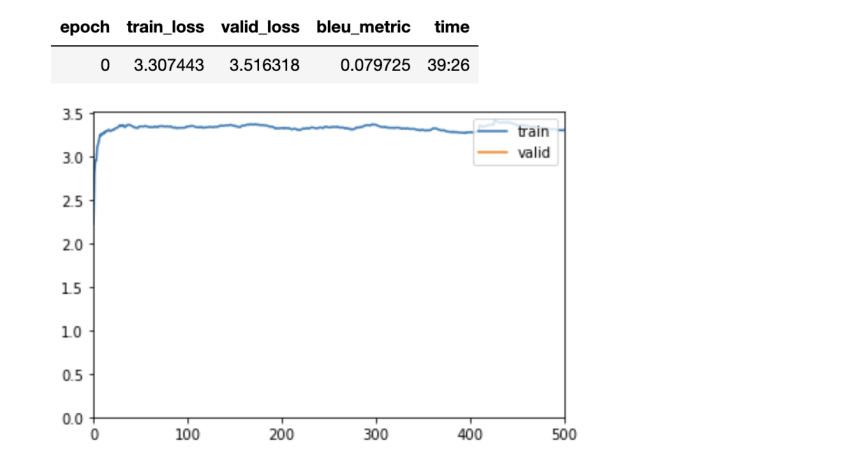

In [31]:
img = plt.imread('report/unfreeze_train.png')
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(img)

## Multilabel Classification

We also tried to formulate this problem as multi-label classification task, where the classes are the subwords embedded in the image.

Here is the sample input, 

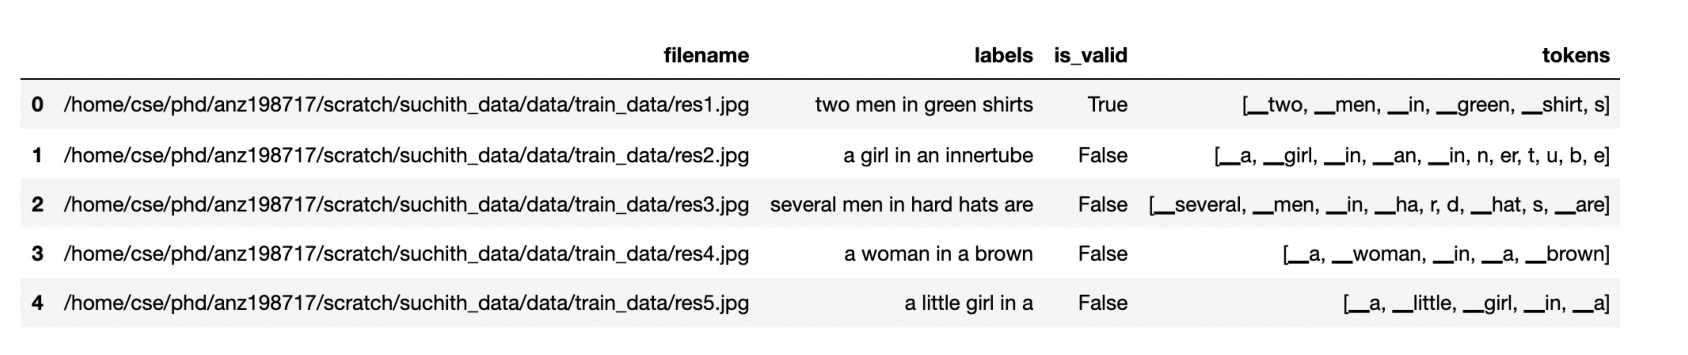

In [7]:
img = plt.imread('/Users/suchith720/Desktop/multilabel_data.png')
plt.figure(figsize=(30, 10))
plt.axis('off')
plt.imshow(img)

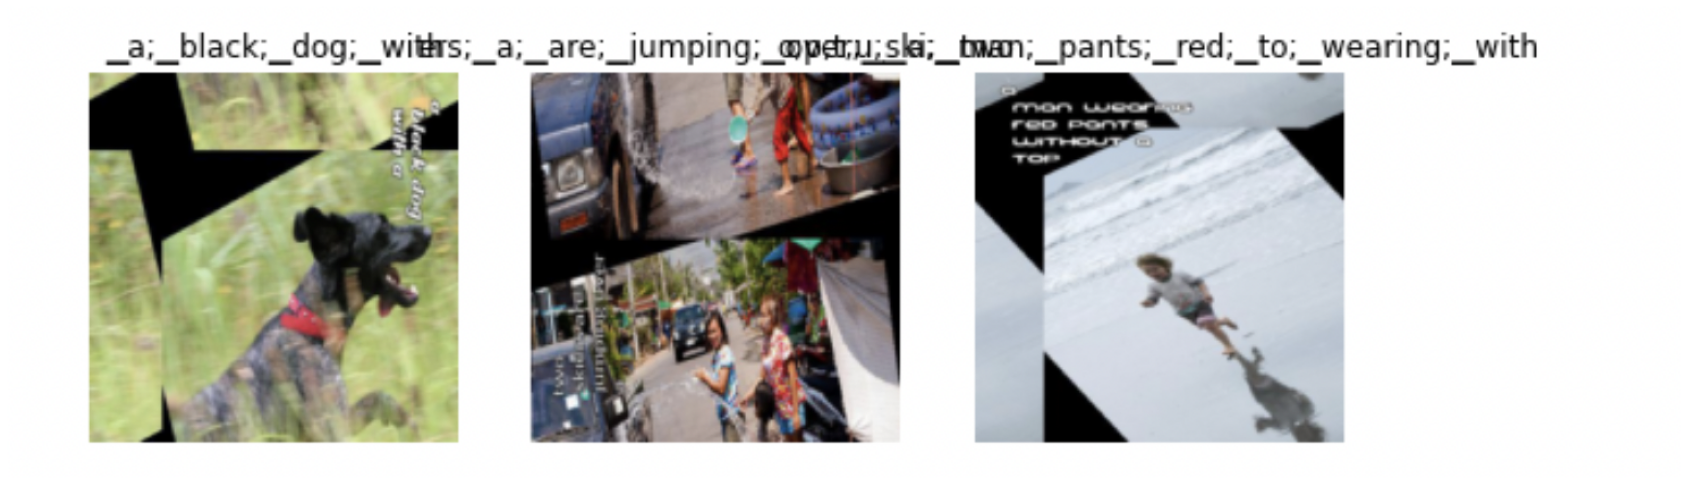

In [8]:
img = plt.imread('/Users/suchith720/Desktop/multi_class.png')
plt.figure(figsize=(30, 10))
plt.axis('off')
plt.imshow(img)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, 
                                                   thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

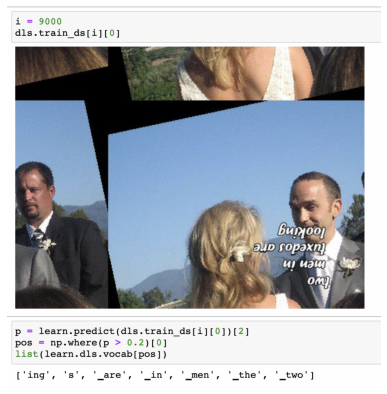

In [22]:
img = plt.imread('/Users/suchith720/Desktop/multi_pred.png')
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(img)

The result that we got from this approach was also not satisfactory.

## Subword-Multiclass Image Extraction

We also tried to train the model on text tokenized at subword level, using the multi-label encoder trained above, below are the metrics during the training time

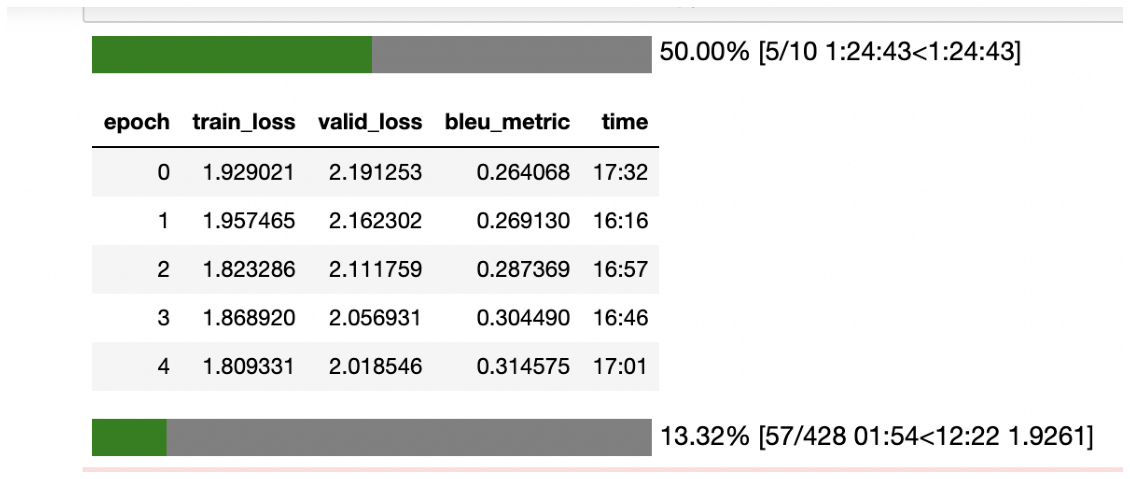

In [17]:
img = plt.imread('/Users/suchith720/Desktop/subword.png')
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img)

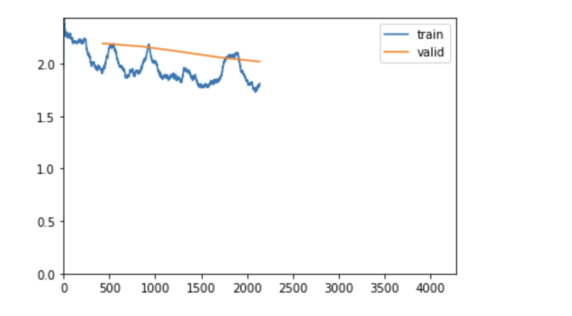

In [20]:
img = plt.imread('/Users/suchith720/Desktop/subword_train.png')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img)

The result on the leaderboard that we got from a trained model was using this method.

# Results and Conclusion

* Training with the new dataset where the text regions was extracted from the image did not help us much.

Looking at the word distribution of the embedded text in the image, we can see below that it is very skewed. So as our baseline we found the top 8 occuring words in datasets and submitted it to the leaderboard as prediction of each image. We choose 8 at it was the average size of the embedded text. With this we got BLEU score of 0.16, which we could not beat with our trained model.

In [38]:
tokenizer = Tokenizer()
train_captions_tokenized = pickle.load(open("data/train_captions.pkl", 'rb'))

In [39]:
token_count = {}
for cap in train_captions_tokenized:
    for t in cap:
        token_count[t] = token_count.get(t, 0) + 1

In [40]:
w, c = zip(*token_count.items())
w = np.array(w)
c = np.array(c)
b = sort_pos = np.argsort(c)

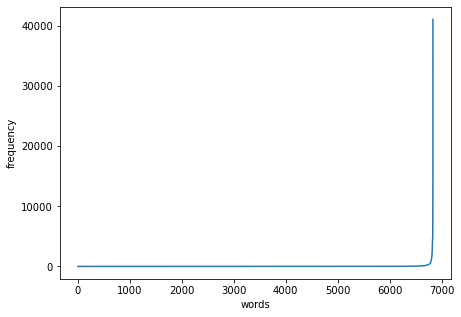

In [47]:
sorted_w = w[sort_pos]
sorted_c = c[sort_pos]
plt.figure(figsize=(7,5))
plt.ylabel('frequency')
plt.xlabel('words')
plt.plot(sorted_c)

We predicted `on two the woman is man in a` for each test image.

We believe that this was one of the main reason why we were not able to train the model, due to the skewed distribution of the words. So considering other ways of representation like the subword-level tokenization has helped us a lot to train the model.

Below is the distribution of the tokens after the subword level tokeniztion.

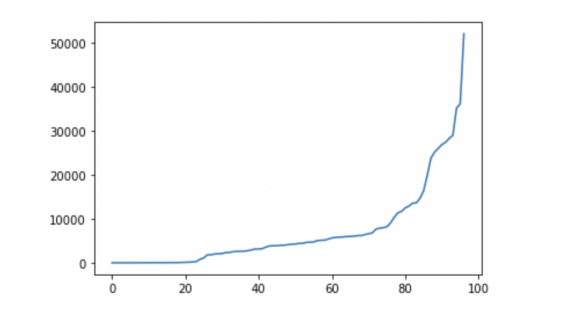

In [21]:
img = plt.imread('/Users/suchith720/Desktop/subword_dist.png')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img)

We can see from the attention heatmap that the model has learnt to read the text in the image from left to right.
We have also seen that this model is doing very good at Image Captioning than Text Extraction.

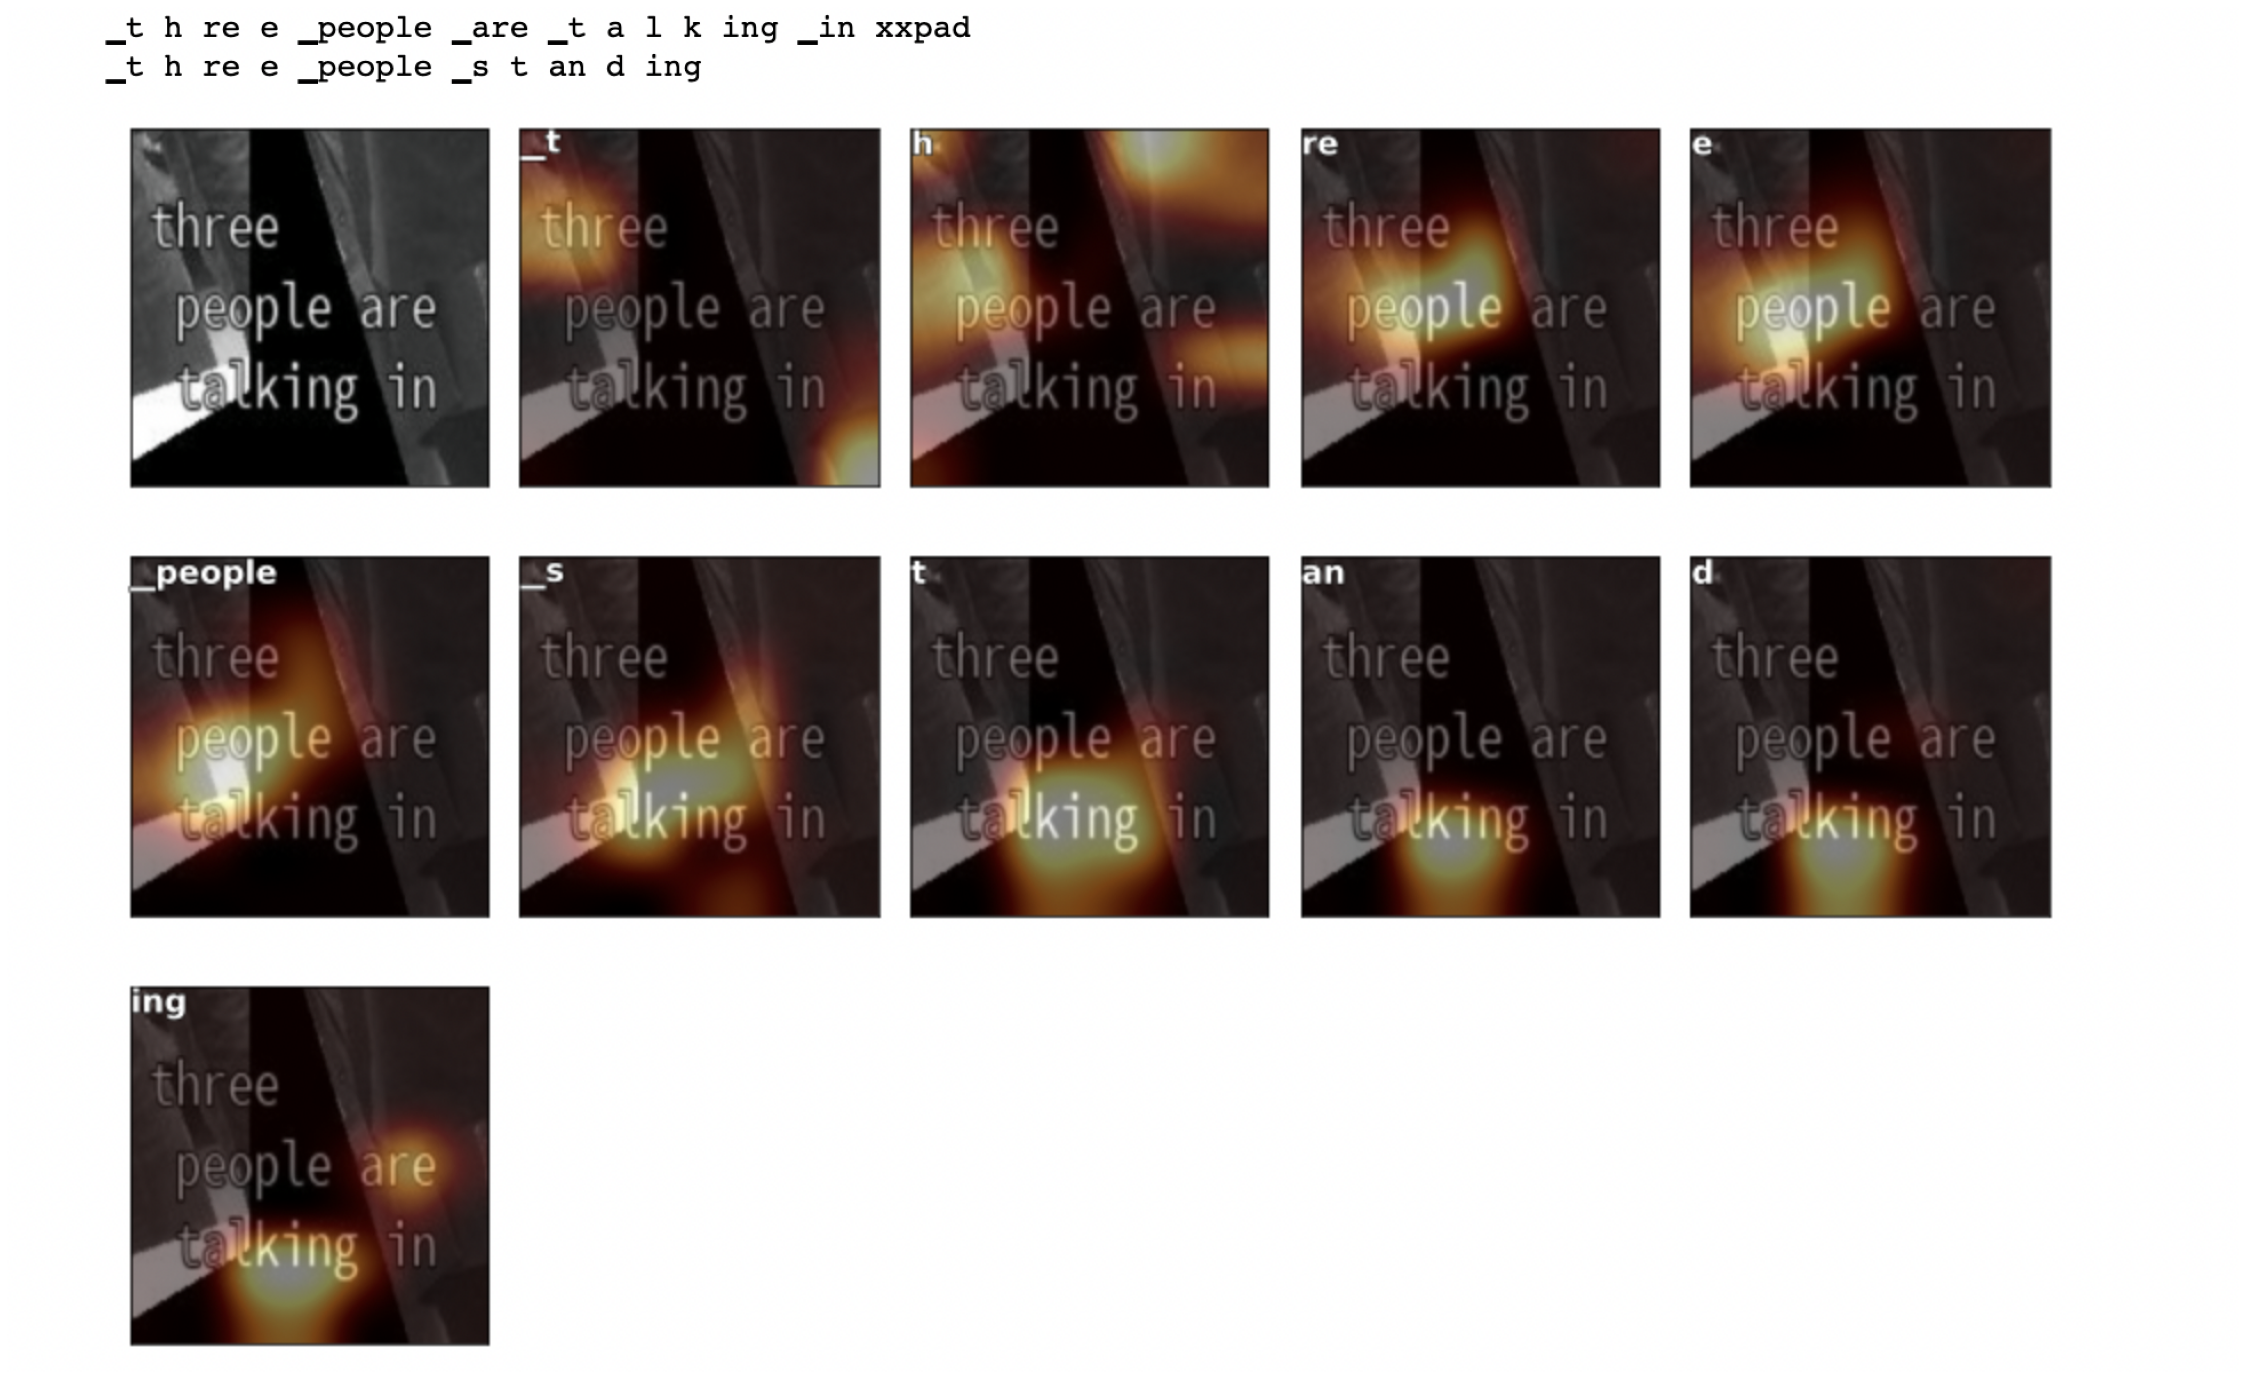

In [13]:
img = plt.imread('/Users/suchith720/Desktop/attention.png')
plt.figure(figsize=(40, 40))
plt.axis('off')
plt.imshow(img)

Here are the scores of our submission on the leaderload,

|   | bleu |
| --- | --- |
| baseline | 0.1596 |
| assignment dataset | 0.10317 |
| new dataset | 0.11187 |
| Multi-label | 0.103502 |
| Pretrained Multi-label| 0.1270 |

# References

We have heavily relied on code present in this [github](https://github.com/fg91/Neural-Image-Caption-Generation-Tutorial) repository for our work. 